In [ ]:
using BenchmarkTools
using Plots

include("../src/Cosmojuly.jl")
import .Cosmojuly as cj

In [ ]:
using Plots

Mhost_init = 1e+12
Mres = 1e+0

Mhost = 10.0.^range(log10(2.1*Mres), log10(Mhost_init), 200)

function_P, function_F = cj.interpolate_functions_PF(Mhost_init, Mres)

plot(Mhost, cj.mean_number_progenitors.(Mhost/2.0, Mhost, Mres), xscale=:log10,  linestyle=:solid, yscale=:log10)
plot!(Mhost, function_P.(Mhost, Mres), xscale=:log10, linestyle=:dash, linewidth=4, yscale=:log10)

In [ ]:
using Plots

Mhost_init = 1e+12
Mres = 1e+2

Mhost = 10.0.^range(log10(2*Mres), log10(Mhost_init), 200)

function_P, function_F = cj.interpolate_functions_PF(Mhost_init, Mres)

plot(Mhost, cj.mass_fraction_unresolved.(Mhost, Mres), xscale=:log10,  linestyle=:solid)
plot!(Mhost, function_F.(Mhost), xscale=:log10, linestyle=:dash, linewidth=4)

In [ ]:
using Plots

M1   = 1e+12
M2 = 10.0.^range(2, log10(M1), 200)

plot(M2[M2.>1e+8], cj.pdf_progenitors.(M2[M2.>1e+8], M1, 1e+8), xscale=:log10, yscale=:log10)
plot!(M2[M2.>1e+5], cj.pdf_progenitors.(M2[M2.>1e+5], M1, 1e+5), xscale=:log10, yscale=:log10)
plot!(M2[M2.>1e+2], cj.pdf_progenitors.(M2[M2.>1e+2], M1, 1e+2), xscale=:log10, yscale=:log10)

In [ ]:
using Plots

M1   = 1e+12
M2 = 10.0.^range(0, log10(M1), 100)

#plot(M2, cj.cmf_progenitors.(M2, M1, 1e+8) .- 0.2, xscale=:log10)
#plot!(M2, cj.cmf_progenitors.(M2, M1, 1e+5).- 0.2, xscale=:log10)
#plot!(M2, cj.cmf_progenitors.(M2, M1, 1e+2).- 0.2, xscale=:log10)

M1   = 250
M2 = 10.0.^range(1.5, log10(M1), 1000)

#plot(M2, cj.cmf_progenitors.(M2, M1, 1e+8).- 0.2, xscale=:log10, linestyle=:dash)
#plot!(M2, cj.cmf_progenitors.(M2, M1, 1e+5).- 0.2, xscale=:log10, linestyle=:dash)
plot(M2, cj.cmf_progenitors.(M2, M1, 1e+2), xscale=:log10, linestyle=:dash)

In [ ]:
itp_z_vs_Δω = cj.interpolate_functions_z()

In [ ]:
subhalo_mass1, m_host1, z_steps1, z_acc1 = cj.subhalo_mass_function(1e+12, 1e+8, z_vs_Δω = itp_z_vs_Δω)

In [ ]:
subhalo_mass2, m_host2, z_steps2, z_acc2 = cj.subhalo_mass_function(1e+12, 1e+5, z_vs_Δω = itp_z_vs_Δω)

In [ ]:
subhalo_mass3, m_host3, z_steps3, z_acc3 = cj.subhalo_mass_function(1e+12, 1e+6,  z_vs_Δω = itp_z_vs_Δω)

In [ ]:
using Plots

m_array = 10.0.^range(-8, stop=1, length=1000)
#CMF1 = [count(x -> x > m, subhalo_mass1) for m in m_array]
CMF2 = [count(x -> x > m, subhalo_mass2) for m in m_array]
CMF3 = [count(x -> x > m, subhalo_mass3) for m in m_array]

#plot(m_array[CMF1 .> 0], CMF1[CMF1 .> 0], xscale=:log10, yscale=:log10, color=:blue)
plot(m_array[CMF2 .> 0], CMF2[CMF2 .> 0], xscale=:log10, yscale=:log10, color=:red)
plot!(m_array[CMF3 .> 0], CMF3[CMF3 .> 0], xscale=:log10, yscale=:log10, color=:green)

In [ ]:
using SpecialFunctions
using LsqFit

function γ2(γ1::Real, α1::Real, α2::Real, β::Real, ζ::Real) 
    int1 =  β.^(.-(2.0.-α1)./ζ) .* gamma.((2.0.-α1)./ζ) .*  gamma_inc.((2.0.-α1)./ζ, β)[1] ./ ζ 
    int2 =  β.^(.-(2.0.-α2)./ζ) .* gamma.((2.0.-α2)./ζ) .*  gamma_inc.((2.0.-α2)./ζ, β)[1] ./ ζ 
    return (1.0 .- γ1 .* int1) ./  int2
end

function fitting_function(m_m0, γ1, α1, α2, β, ζ)
    if α1 > 2 || α1 < 1 || α2 > 2 || α2 < 1 || β < 0 || ζ < 0 || γ1 < 0
        return Inf
    end
    return γ1./ζ .* ((m_m0).^(1.0.-α1) .* expint.((α1.-1.0)./ζ .+ 1.0, β.*(m_m0).^ζ) .- expint.((α1.-1.0)./ζ .+ 1.0, β)) .+  γ2(γ1, α1, α2, β, ζ)./ζ .* ((m_m0).^(1.0.-α2) .* expint.((α2.-1.0)./ζ .+ 1.0, β.*(m_m0).^ζ) .- expint.((α2.-1.0)./ζ .+ 1.0, β)) 
end

p0 = [0.019, 1.94, 1.58, 24, 3.4]

model(t, p) = @. log10.(fitting_function(10.0.^t, p[1], p[2], p[3], p[4], p[5]))

fit = curve_fit(model, log10.(m_array[CMF3 .> 0]), log10.(CMF3[CMF3 .> 0]), p0)

println(fit.param)
println(γ2(fit.param...))

res = 10.0.^model(log10.(m_array), fit.param) #fitting_function(1e+12 .* m_array, 1e+12, fit.param...)
plot(m_array[res .> 0], res[res .> 0], xscale=:log10, yscale=:log10, ylim=[1e-1, 1e+5])
plot!(m_array[CMF3 .> 0], CMF3[CMF3 .> 0], xscale=:log10, yscale=:log10, ylim=[1e-1, 1e+5])

In [ ]:
#plot(z_steps1, m_host1, yscale=:log10, color=:blue)
plot(z_steps2, m_host2, yscale=:log10, color=:red)
plot!(z_steps3, m_host3, yscale=:log10, color=:green)

In [ ]:
#plot(subhalo_mass1, z_acc1, seriestype=:scatter, xscale=:log10, markersize = 2, yscale=:log10)
plot(subhalo_mass2, z_acc2, seriestype=:scatter, xscale=:log10, markersize = 2, yscale=:log10)
plot!(subhalo_mass3, z_acc3, seriestype=:scatter, xscale=:log10, markersize = 2, yscale=:log10)

In [ ]:
import StatsBase as SB
using Plots

id_6 = (subhalo_mass2 .> 1e-6) .& (subhalo_mass2 .< 1e-5)
id_5 = (subhalo_mass2 .> 1e-5) .& (subhalo_mass2 .< 1e-4)
id_4 = (subhalo_mass2 .> 1e-4) .& (subhalo_mass2 .< 1e-3)
id_3 = (subhalo_mass2 .> 1e-3) .& (subhalo_mass2 .< 1e-2)
#println(count(x -> x === true, id_4))

#result6 = SB.fit(Histogram, log10.(z_acc3[id_6]), nbins=40)
#result5 = SB.fit(Histogram, log10.(z_acc3[id_5]), nbins=40)
#plot(result6.edges[1][2:end], log10.(result6.weights), st=:stairs)
#plot!(result5.edges[1][2:end], log10.(result5.weights), st=:stairs)

histogram(log10.(z_acc2[id_6]), normalize=:pdf)
histogram!(log10.(z_acc2[id_5]), normalize=:pdf)
histogram!(log10.(z_acc2[id_4]), normalize=:pdf)

In [ ]:
#Mres = 1e+2

#println((1.0 .- 10.0.^random))

#plot(heatmap(random, log10.(M1_array), log10.(cj.cmf_inv_progenitors.((1.0 .- 10.0.^random)', M1_array, 1e+5))), c = :thermal)

In [55]:
include("../src/Cosmojuly.jl")
import .Cosmojuly as cj


mres = 1e+2
mhost = 1e+12

itp_S_vs_mass, itp_dS_vs_mass = cj.interpolate_S_vs_mass()
cj._save_cmf_inv_progenitors(mhost, mres, itp_S_vs_mass, itp_dS_vs_mass, p_array_size=101, mass_array_size=101)

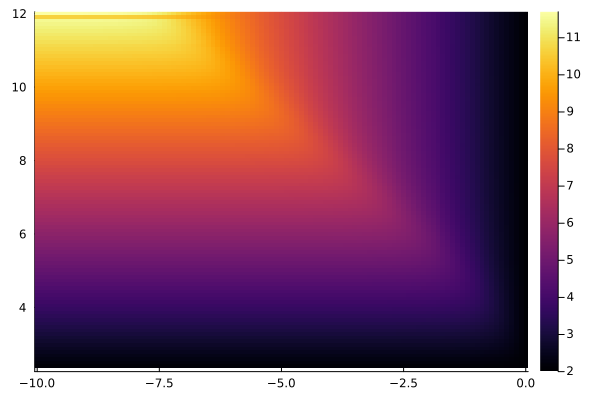

In [58]:
using Plots

q = range(-10, 0, length=101)
m1_array = 10.0.^range(log10(2.0001*mres), log10(mhost), length=101)

func = cj._load_cmf_inv_progenitors(mhost, mres, itp_S_vs_mass, itp_dS_vs_mass)
plot(heatmap(q, log10.(m1_array), log10.(func.((1.0 .- 10.0.^q)', m1_array))), c = :thermal)

In [39]:
func(0.99, 1e+12)

BoundsError: BoundsError: attempt to access 20×20 interpolate((-10.0:0.42105263157894735:-2.0,::Vector{Float64}), ::Matrix{Float64}, Gridded(Linear())) with element type Float64 at index [-1.9999999999999996, 12.0]

In [ ]:
include("../src/Cosmojuly.jl")
import .Cosmojuly as cj

itp_z_vs_Δω = cj.interpolate_functions_z()

z_bins, mass_edges, z_edges = cj.subhalo_mass_function_binned(1e+12, 1e+2, z_vs_Δω = itp_z_vs_Δω)

In [ ]:
using Plots

#plot(z_edges[1:end-1], z_bins[10,:], xscale=:log10, seriestype=:stairs)
mass_bins = sum(z_bins, dims=2)[:]
plot(mass_edges[1:end-1][mass_bins .> 0], log(10) .* mass_bins[mass_bins .> 0], xscale=:log10, yscale=:log10, seriestype=:stairs)

In [ ]:
using Plots

edges = z_edges[1:end-1]
data1 = z_bins[1,:]
data2 = z_bins[50,:]

plot(edges[data1 .> 0], data1[data1 .> 0], xscale=:log10, yscale=:log10, seriestype=:stairs)
plot!(edges[data2 .> 0], data2[data2 .> 0], xscale=:log10, yscale=:log10, seriestype=:stairs)

In [14]:
include("../src/Cosmojuly.jl")
import .Cosmojuly as cj
using BenchmarkTools

itp_S_vs_mass, itp_dS_vs_mass = cj.interpolate_S_vs_mass()

#@benchmark cj.mean_number_progenitors(1e+11, 1e+12, 1e+2, itp_S_vs_mass, itp_dS_vs_mass)

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  404.458 μs …   6.639 ms  ┊ GC (min … max): 0.00% … 93.03%
 Time  (median):     413.291 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   441.170 μs ± 321.186 μs  ┊ GC (mean ± σ):  4.57% ±  5.81%

  ▄▃█▇▄▃▃▂▂▁▁▁▁▁                                                ▁
  ████████████████████▇▇▇▆▅▆▆▆▆▆▆▅▅▅▅▅▅▄▆▅▅▅▅▅▅▅▄▃▅▄▄▃▂▄▂▃▄▃▄▃▄ █
  404 μs        Histogram: log(frequency) by time        584 μs <

 Memory estimate: 256.75 KiB, allocs estimate: 13358.

(::Main.Cosmojuly.MassFunction.var"#itp_mass_vs_S#10"{Interpolations.GriddedInterpolation{Float64, 1, Vector{Float64}, Interpolations.Gridded{Interpolations.Linear{Interpolations.Throw{Interpolations.OnGrid}}}, Tuple{StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}}}}) (generic function with 1 method)